# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0



#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
file_path = "ingredient_and_quantity.json" 
df = load_json_dataframe(file_path)

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df

print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder D

In [8]:
# print the dimensions of dataframe - df
print(f"DataFrame Dimensions: {df.shape}")

DataFrame Dimensions: (285, 2)


In [9]:
# print the information of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [10]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
df['input_tokens'] = df['input'].apply(lambda x: x.split() if pd.notnull(x) else [])
# Tokenize POS
df['pos_tokens'] = df['pos'].apply(lambda x: x.split() if pd.notnull(x) else [])

In [11]:
# display first five rows of the dataframe - df
print(f"First five roaws of the input_tokens:")
print(df['input_tokens'].head())

print(f"First five roaws of the pos_tkens:")
print(df['pos_tokens'].head())

First five roaws of the input_tokens:
0                                                                                                                  [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]
1                                                                                                  [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]
2                                                                             [1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, 

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [12]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

In [13]:
# check for the equality of input_length and pos_length in the dataframe
unequal_rows = df[df['input_length'] != df['pos_length']]

# Display the rows with unequal lengths
print(f"Number of rows with unequal lengths: {len(unequal_rows)}")

Number of rows with unequal lengths: 5


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [14]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df):
    unique_labels_set = set(label for labels in df['pos_tokens'] for label in labels)
    print(f"Unique POS Labels: {unique_labels_set}")
    return unique_labels_set

unique_labels_set = unique_labels(df)

Unique POS Labels: {'quantity', 'ingredient', 'unit'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [15]:
# drop the irrelevant recipe data
df = df[df['input_length'] == df['pos_length']].reset_index(drop=True)
print(f"Updated DataFrame Dimensions: {df.shape}")

Updated DataFrame Dimensions: (280, 6)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [16]:
# update the input and pos length in input_length and pos_length

df['input_length'] = df['input_tokens'].apply(len)
df['pos_length'] = df['pos_tokens'].apply(len)

print(df[['input_length', 'pos_length']].head())

   input_length  pos_length
0            31          31
1            34          34
2            37          37
3            46          46
4            21          21


##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [17]:
# validate the input length and pos length as input_length and pos_length

unequal_rows = df[df['input_length'] != df['pos_length']]

print(f"Number of rows with unequal lengths: {len(unequal_rows)}")
if not unequal_rows.empty:
    print("Rows with unequal lengths:")
    print(unequal_rows)
else:
    print("All rows have equal input_length and pos_length.")

Number of rows with unequal lengths: 0
All rows have equal input_length and pos_length.


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [18]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)

print(f"Training Set Dimensions: {train_df.shape}")
print(f"Validation Set Dimensions: {val_df.shape}")

Training Set Dimensions: (196, 6)
Validation Set Dimensions: (84, 6)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [19]:
# print the first five rows of train_df
print(train_df.head())


                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                       

In [20]:
# print the first five rows of the val_df
print(val_df.head())


                                                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [21]:
# extract the training and validation sets by taking input_tokens and pos_tokens

X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()

X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()


In [22]:
# validate the shape of training and validation samples

print(f"Number of training samples (X_train): {len(X_train)}")
print(f"Number of training labels (y_train): {len(y_train)}")
print(f"Number of validation samples (X_val): {len(X_val)}")
print(f"Number of validation labels (y_val): {len(y_val)}")

Number of training samples (X_train): 196
Number of training labels (y_train): 196
Number of validation samples (X_val): 84
Number of validation labels (y_val): 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [23]:
# Display the number of unique labels present in y_train
unique_labels_in_y_train = set(label for labels in y_train for label in labels)
print(f"Number of unique labels in y_train: {len(unique_labels_in_y_train)}")
print(f"Unique labels in y_train: {unique_labels_in_y_train}")

Number of unique labels in y_train: 3
Unique labels in y_train: {'quantity', 'unit', 'ingredient'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

flattened_input_tokens = flatten_list(df['input_tokens'].tolist())
flattened_pos_tokens = flatten_list(df['pos_tokens'].tolist())


In [27]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [28]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name):

    # Flatten the input_tokens and pos_tokens
    flattened_input_tokens = flatten_list(df['input_tokens'].tolist())
    flattened_pos_tokens = flatten_list(df['pos_tokens'].tolist())
    
    # Validate lengths
    if len(flattened_input_tokens) != len(flattened_pos_tokens):
        print(f"[{dataset_name}] Length mismatch: input_tokens ({len(flattened_input_tokens)}) != pos_tokens ({len(flattened_pos_tokens)})")
    else:
        print(f"[{dataset_name}] Lengths are valid: input_tokens ({len(flattened_input_tokens)}) == pos_tokens ({len(flattened_pos_tokens)})")



In [29]:
# extract the tokens and its pos tags
extract_and_validate_tokens(df, dataset_name)

print(f"\n[{dataset_name}] First 10 input tokens:")
print(flattened_input_tokens[:10])
print(f"\n[{dataset_name}] First 10 POS tokens:")
print(flattened_pos_tokens[:10])

[Training] Lengths are valid: input_tokens (9990) == pos_tokens (9990)

[Training] First 10 input tokens:
['6', 'Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', '1', 'Onion', '3', 'tablespoon']

[Training] First 10 POS tokens:
['quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'unit']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [30]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    ingredients = []
    units = []
    quantities = []

    # Validate that tokens and pos_tags
    if len(tokens) != len(pos_tags):
        print("Error: Tokens and POS tags length mismatch.")
        return [], [], []

    # Categorize tokens based on their POS tags
    for token, pos_tag in zip(tokens, pos_tags):
        if pos_tag == "ingredient":
            ingredients.append(token)
        elif pos_tag == "unit":
            units.append(token)
        elif pos_tag == "quantity":
            quantities.append(token)

    return ingredients, units, quantities

In [31]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

print("Ingredients:", ingredients)
print("Units:", units)
print("Quantities:", quantities)

Ingredients: ['Karela', 'Bitter', 'Gourd', 'Pavakkai', 'Salt', 'Onion', 'Gram', 'flour', 'besan', 'Turmeric', 'powder', 'Haldi', 'Red', 'Chilli', 'Cumin', 'seeds', 'Jeera', 'Coriander', 'Powder', 'Dhania', 'Amchur', 'Dry', 'Mango', 'Sunflower', 'Oil', 'rice', 'cooked', 'tomatoes', 'BC', 'Belle', 'Bhat', 'powder', 'chickpea', 'lentils', 'cumin', 'seeds', 'white', 'urad', 'dal', 'mustard', 'green', 'chilli', 'dry', 'red', 'cashew', 'or', 'peanuts', 'oil', 'asafoetida', 'Rice', 'Vermicelli', 'Noodles', 'Thin', 'Onion', 'sliced', 'Carrots', 'Gajjar', 'chopped', 'Green', 'peas', 'Matar', 'Chillies', 'Asafoetida', 'hing', 'Mustard', 'seeds', 'White', 'Urad', 'Dal', 'Split', 'Ghee', 'Curry', 'leaves', 'Salt', 'Lemon', 'juice', 'Chicken', 'Onion', 'chopped', 'Tomato', 'Green', 'Chillies', 'slit', 'Ginger', 'finely', 'Garlic', 'Turmeric', 'powder', 'Haldi', 'Garam', 'masala', 'Sesame', 'Gingelly', 'Oil', 'Methi', 'Seeds', 'Fenugreek', 'Coriander', 'Dhania', 'Dry', 'Red', 'Fennel', 'seeds', 'Sau

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [32]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, pos_label, dataset_name, top_n=10):
    item_counts = Counter(item_list)
    
    # get top N items
    top_items = item_counts.most_common(top_n)
    
    # display the top items
    print(f"Top {top_n} {pos_label}s in {dataset_name} dataset:")
    for item, count in top_items:
        print(f"{item}: {count}")
    
    return top_items

In [33]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients = get_top_frequent_items(ingredients, "ingredient", dataset_name)
print(top_ingredients)

Top 10 ingredients in Training dataset:
powder: 183
Salt: 149
seeds: 125
Oil: 122
Red: 120
chopped: 115
Green: 115
Chilli: 113
Coriander: 98
Leaves: 94
[('powder', 183), ('Salt', 149), ('seeds', 125), ('Oil', 122), ('Red', 120), ('chopped', 115), ('Green', 115), ('Chilli', 113), ('Coriander', 98), ('Leaves', 94)]


In [34]:
# get the top units which are frequently seen in the recipe
top_units = get_top_frequent_items(units, "unit", dataset_name)
print(top_units)

Top 10 units in Training dataset:
teaspoon: 221
cup: 193
tablespoon: 131
tablespoons: 93
grams: 82
cups: 74
inch: 72
sprig: 62
teaspoons: 57
cloves: 55
[('teaspoon', 221), ('cup', 193), ('tablespoon', 131), ('tablespoons', 93), ('grams', 82), ('cups', 74), ('inch', 72), ('sprig', 62), ('teaspoons', 57), ('cloves', 55)]


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [35]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(top_items, label, dataset_name):

    items, counts = zip(*top_items)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=items, y=counts)
    plt.title(f"Top {len(top_items)} {label}s in {dataset_name} Dataset")
    plt.xlabel("Frequency")
    plt.ylabel(label.capitalize())
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



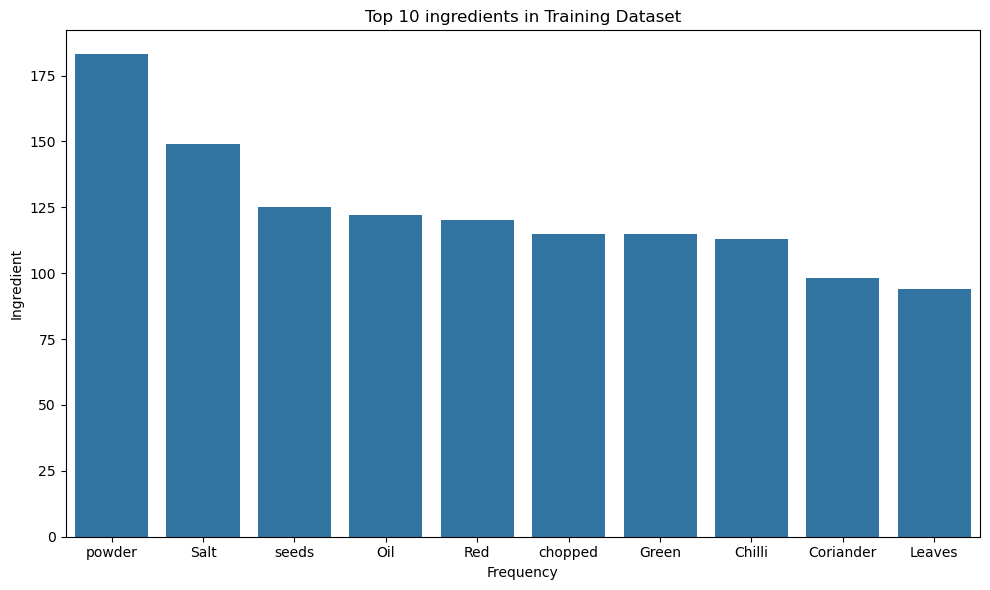

In [36]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, "ingredient", dataset_name)

In [37]:
# plot the top frequent units in training data
plot_top_items(top_units, "units", dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [38]:
# initialise the dataset_name
dataset_name = "Validation"

In [39]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
extract_and_validate_tokens(val_df, dataset_name)

flattened_input_tokens = flatten_list(val_df['input_tokens'].tolist())
flattened_pos_tokens = flatten_list(val_df['pos_tokens'].tolist())

ingredients, units, quantities = categorize_tokens(flattened_input_tokens, flattened_pos_tokens)

[Validation] Lengths are valid: input_tokens (2876) == pos_tokens (2876)


Top 10 ingredients in Validation dataset:
powder: 54
Salt: 47
Oil: 39
Red: 39
seeds: 36
Chilli: 36
chopped: 31
Green: 30
Leaves: 29
Coriander: 27


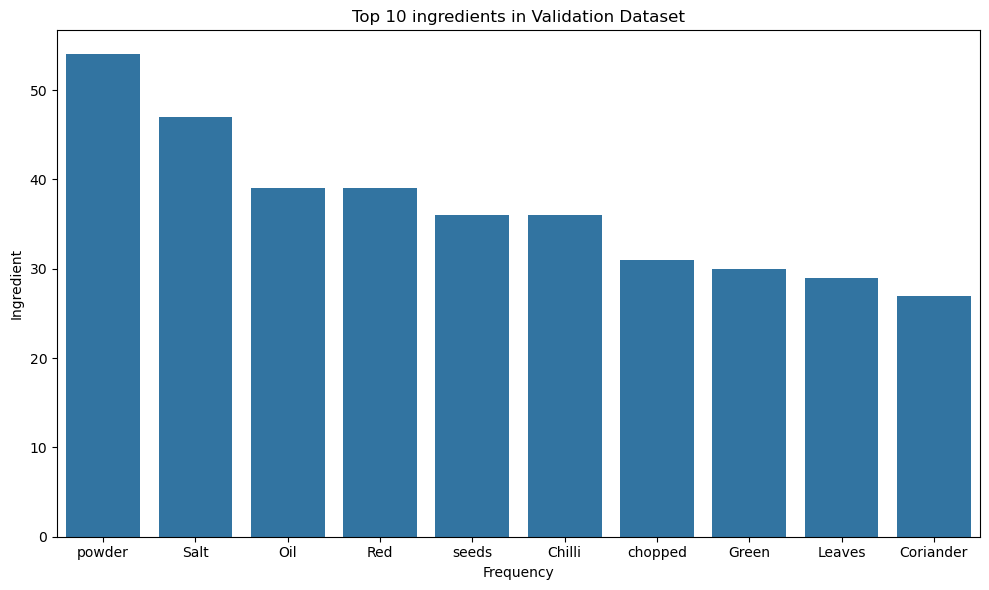

In [40]:
# plot the top frequent ingredients in validation data
top_ingredients_validation = get_top_frequent_items(ingredients, "ingredient", dataset_name)

plot_top_items(top_ingredients_validation, "ingredient", dataset_name)

In [41]:
# plot the top frequent units in training data
top_units_validation = get_top_frequent_items(units, "unit", dataset_name)
plot_top_items(top_units_validation, "unit", dataset_name)

Top 10 units in Validation dataset:
teaspoon: 59
cup: 57
tablespoon: 32
tablespoons: 32
cups: 24
sprig: 21
inch: 20
grams: 19
teaspoons: 18
cloves: 16


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [42]:
# define unit and quantity keywords along with quantity pattern
unit_keywords = {"cup", "cups", "tablespoon", "tablespoons", "teaspoon", "teaspoons", "tbsp", "tsp", "gram", "grams", "kg", "kilogram", "ml", "liter", "liters", "oz", "ounce", "ounces", "pound", "pounds"}
quantity_keywords = {"half", "quarter", "third", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"}

quantity_pattern = re.compile(r"^\d+(\.\d+)?(\/\d+)?$") 

In [100]:
# load spaCy model
nlp = spacy.load("en_core_web_sm")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [101]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent, i):

    doc = nlp(" ".join(sent))
    token = doc[i]

    # --- Core Features ---
    features = {
        'bias': 1.0,
        'token': token.text.lower(),
        'lemma': token.lemma_.lower(),
        'pos_tag': token.pos_,
        'tag': token.tag_,
        'dep': token.dep_,
        'shape': token.shape_,
        'is_stop': token.is_stop,
        'is_digit': token.is_digit,
        'has_digit': any(char.isdigit() for char in token.text),
        'has_alpha': any(char.isalpha() for char in token.text),
        'hyphenated': '-' in token.text,
        'slash_present': '/' in token.text,
        'is_title': token.is_title,
        'is_upper': token.is_upper,
        'is_punct': token.is_punct,
    }

    # --- Improved Quantity & Unit Detection ---
    features.update({
        'is_quantity': token.text.lower() in quantity_keywords or quantity_pattern.match(token.text),
        'is_unit': token.text.lower() in unit_keywords,
        'is_numeric': token.text.isnumeric(),
        'is_fraction': '/' in token.text,
        'is_decimal': '.' in token.text,
    })

    # --- Contextual Features ---
    if i > 0:
        prev_token = doc[i - 1]
        features.update({
            'prev_token': prev_token.text.lower(),
            'prev_is_quantity': prev_token.text.lower() in quantity_keywords or quantity_pattern.match(prev_token.text),
            'prev_is_digit': prev_token.is_digit,
        })
    else:
        features['BOS'] = True  # Beginning of Sentence
        

    if i < len(doc) - 1:
        next_token = doc[i + 1]
        features.update({
            'next_token': next_token.text.lower(),
            'next_is_unit': next_token.text.lower() in unit_keywords,
            'next_is_ingredient': next_token.text.lower() not in unit_keywords and next_token.text.lower() not in quantity_keywords,
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [118]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [119]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(sent) for sent in X_train]
X_val_features = [sent2features(sent) for sent in X_val]

print(f"Number of training feature sets: {len(X_train_features)}")
print(f"Number of validation feature sets: {len(X_val_features)}")

Number of training feature sets: 196
Number of validation feature sets: 84


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [120]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = [list(labels) for labels in y_train]
y_val_labels = [list(labels) for labels in y_val]

print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")

Number of training labels: 196
Number of validation labels: 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [121]:
# print the length of train features and labels
print(f"Length of training features (X_train_features): {len(X_train_features)}")
print(f"Length of training labels (y_train_labels): {len(y_train_labels)}")

Length of training features (X_train_features): 196
Length of training labels (y_train_labels): 196


In [122]:
# print the length of validation features and labels
print(f"Length of validation features (X_val_features): {len(X_val_features)}")
print(f"Length of validation labels (y_val_labels): {len(y_val_labels)}")

Length of validation features (X_val_features): 84
Length of validation labels (y_val_labels): 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [123]:
# Flatten labels in y_train
y_train_flat = [label for labels in y_train for label in labels]

print(f"Number of flattened labels in y_train: {len(y_train_flat)}")

Number of flattened labels in y_train: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [124]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

label_counts = Counter(y_train_flat)

total_samples = sum(label_counts.values())

print(f"Label Counts: {label_counts}")
print(f"Total Samples: {total_samples}")

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [125]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {label: total_samples / count for label, count in label_counts.items()}

print("Class Weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight}")


Class Weights:
quantity: 7.259183673469388
unit: 8.771886559802713
ingredient: 1.336464399774563


In [126]:
# penalise ingredient label
penalty_factor = 0.5  # Adjust this factor as needed
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= penalty_factor

print("Updated Class Weights (with penalty on 'ingredient'):")
for label, weight in weight_dict.items():
    print(f"{label}: {weight}")

Updated Class Weights (with penalty on 'ingredient'):
quantity: 7.259183673469388
unit: 8.771886559802713
ingredient: 0.6682321998872816


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [127]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    weighted_features = []
    
    for sent, labels in zip(X, y):
        sentence_features = []
        for i, label in enumerate(labels):
            # Extract features for the token
            token_features = word2features(sent, i)
            
            # Apply class weight to the token's features
            token_features['class_weight'] = weight_dict.get(label, 1.0)
            
            sentence_features.append(token_features)
        weighted_features.append(sentence_features)
    
    return weighted_features


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [128]:
# Apply manually computed class weights
X_train_weighted_features = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features = extract_features_with_class_weights(X_val, y_val, weight_dict)

print(f"Number of weighted training feature sets: {len(X_train_weighted_features)}")
print(f"Number of weighted validation feature sets: {len(X_val_weighted_features)}")

Number of weighted training feature sets: 196
Number of weighted validation feature sets: 84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [130]:
# initialise CRF model with the specified hyperparameters and use weight_dict

!pip install  sklearn_crfsuite==0.5.0
from sklearn_crfsuite import CRF

# Initialize CRF model with specified hyperparameters
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,  # L1 regularization
    c2=1.0,  # L2 regularization
    max_iterations=100,
    all_possible_transitions=True
)

# Train the CRF model with the weighted training data
crf_model.fit(X_train, y_train_labels)

print("CRF model has been initialized and trained successfully.")


CRF model has been initialized and trained successfully.


### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [131]:
# evaluate on the training dataset

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred_train = crf_model.predict(X_train)
print("Classification Report on Training Dataset:")
print(flat_classification_report(y_train_labels, y_pred_train))

y_train_flat = [label for labels in y_train_labels for label in labels]
y_pred_train_flat = [label for labels in y_pred_train for label in labels]

# confusion matrix
labels = list(crf_model.classes_)
conf_matrix = confusion_matrix(y_train_flat, y_pred_train_flat, labels=labels)

print("\nConfusion Matrix on Training Dataset:")
print(pd.DataFrame(conf_matrix, index=labels, columns=labels))

Classification Report on Training Dataset:
              precision    recall  f1-score   support

  ingredient       0.98      0.98      0.98      5323
    quantity       0.99      0.98      0.99       980
        unit       0.90      0.90      0.90       811

    accuracy                           0.97      7114
   macro avg       0.96      0.96      0.96      7114
weighted avg       0.97      0.97      0.97      7114


Confusion Matrix on Training Dataset:
            quantity  unit  ingredient
quantity         962     0          18
unit               0   732          79
ingredient         7    77        5239


In [132]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite.metrics import flat_classification_report

# Predict on the training dataset
y_pred_train = crf_model.predict(X_train)

print("Flat Classification Report on Training Dataset:")
print(flat_classification_report(y_train_labels, y_pred_train))


Flat Classification Report on Training Dataset:
              precision    recall  f1-score   support

  ingredient       0.98      0.98      0.98      5323
    quantity       0.99      0.98      0.99       980
        unit       0.90      0.90      0.90       811

    accuracy                           0.97      7114
   macro avg       0.96      0.96      0.96      7114
weighted avg       0.97      0.97      0.97      7114



In [133]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
import pandas as pd

# Flatten the true and predicted labels for the training dataset
y_train_flat = [label for labels in y_train_labels for label in labels]
y_pred_train_flat = [label for labels in y_pred_train for label in labels]

# Generate confusion matrix
labels = list(crf_model.classes_)
conf_matrix = confusion_matrix(y_train_flat, y_pred_train_flat, labels=labels)

conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

print("Confusion Matrix on Training Dataset:")
print(conf_matrix_df)

Confusion Matrix on Training Dataset:
            quantity  unit  ingredient
quantity         962     0          18
unit               0   732          79
ingredient         7    77        5239


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [136]:
# dump the model using joblib as crf_model.pkl
import joblib

joblib.dump(crf_model, "crf_model.pkl")

print("CRF model has been saved 'crf_model.pkl'.")

CRF model has been saved 'crf_model.pkl'.


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [137]:
# predict the crf model on validation dataset
y_pred_val = crf_model.predict(X_val)

print("Predictions on the validation dataset have been generated.")


Predictions on the validation dataset have been generated.


In [138]:
# specify flat classification report
from sklearn_crfsuite.metrics import flat_classification_report

print("Flat Classification Report on Validation Dataset:")
print(flat_classification_report(y_val_labels, y_pred_val))

Flat Classification Report on Validation Dataset:
              precision    recall  f1-score   support

  ingredient       0.97      0.98      0.97      2107
    quantity       0.99      0.99      0.99       411
        unit       0.86      0.85      0.86       358

    accuracy                           0.96      2876
   macro avg       0.94      0.94      0.94      2876
weighted avg       0.96      0.96      0.96      2876



In [140]:
# create a confusion matrix on validation dataset
from sklearn.metrics import confusion_matrix
import pandas as pd

# Flatten the true and predicted labels
y_val_flat = [label for labels in y_val_labels for label in labels]
y_pred_val_flat = [label for labels in y_pred_val for label in labels]

# Generate confusion matrix
labels = list(crf_model.classes_)
conf_matrix = confusion_matrix(y_val_flat, y_pred_val_flat, labels=labels)

conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
print("Confusion Matrix on Validation Dataset:")
print(conf_matrix_df)

Confusion Matrix on Validation Dataset:
            quantity  unit  ingredient
quantity         405     1           5
unit               1   305          52
ingredient         4    48        2055


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [141]:
# flatten Labels and Initialise Error Data
y_val_flat = [label for labels in y_val_labels for label in labels]
y_pred_val_flat = [label for labels in y_pred_val for label in labels]

error_data = []
print("Labels have been flattened, and error data has been initialized.")

Labels have been flattened, and error data has been initialized.


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [142]:
# iterate and collect Error Information

for sent, true_labels, pred_labels in zip(X_val, y_val_labels, y_pred_val):
    for i, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
        if true_label != pred_label:  # Check for misclassification
            # Get the current token
            token = sent[i]
            
            # Get previous and next tokens with handling for boundary cases
            prev_token = sent[i - 1] if i > 0 else None
            next_token = sent[i + 1] if i < len(sent) - 1 else None
            
            # Collect error information
            error_data.append({
                "token": token,
                "true_label": true_label,
                "predicted_label": pred_label,
                "prev_token": prev_token,
                "next_token": next_token,
                "context": " ".join(sent)  # Full sentence for context
            })

print("Error information has been collected.")

Error information has been collected.


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [143]:
# Create DataFrame and Print Overall Accuracy
error_df = pd.DataFrame(error_data)

total_predictions = len(y_val_flat)
correct_predictions = total_predictions - len(error_df)
overall_accuracy = correct_predictions / total_predictions

print("Error DataFrame:")
print(error_df.head())

print(f"\nOverall Accuracy on Validation Dataset: {overall_accuracy:.2%}")

Error DataFrame:
     token  true_label predicted_label prev_token next_token                                                                                                                                                                                                                                                                                                                                                                    context
0    liter        unit      ingredient          2       Milk                                                                                                                                                                                                                                                                                      1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/2 teaspoon Cardamom Powder Elaichi
1  coconut  ingredient            unit      Fresh     grated  1 Carrot Gajjar chopped 7 Potatoes Aloo 2 cups Cauliflower gobi cut to sm

##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [144]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

label_error_counts = error_df['true_label'].value_counts()
label_total_counts = pd.Series(y_val_flat).value_counts()

# Calculate accuracy
label_accuracy = {
    label: (label_total_counts[label] - label_error_counts.get(label, 0)) / label_total_counts[label]
    for label in label_total_counts.index
}

print("Class Weights:")
for label, weight in weight_dict.items():
    print(f"{label}: {weight}")

print("\nLabel-wise Accuracy:")
for label, accuracy in label_accuracy.items():
    print(f"{label}: {accuracy:.2%}")

print("\nError DataFrame:")
print(error_df[['token', 'prev_token', 'next_token', 'true_label', 'predicted_label', 'context']].head())

Class Weights:
quantity: 7.259183673469388
unit: 8.771886559802713
ingredient: 0.6682321998872816

Label-wise Accuracy:
ingredient: 97.53%
quantity: 98.54%
unit: 85.20%

Error DataFrame:
     token prev_token next_token  true_label predicted_label                                                                                                                                                                                                                                                                                                                                                                    context
0    liter          2       Milk        unit      ingredient                                                                                                                                                                                                                                                                                      1 cup Ada 2 liter Milk 3/4 Sugar tablespoon Ghee 1/

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.